# (04) Exact recon loss

**Motivation**: Test exact versus mc loss. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Poisson

### MLP

In [3]:
name = '/'.join([
    'poisson_uniform_c(-3)_rmax(1)_DOVES_z-512_k-16_<mlp+b|lin>',
    'mc_b1000-ep3600-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)_(2024_05_05,08:43)',
])
tr, meta = load_quick(name, False, device=device)
print(meta)

{
    'timestamp': '2024_05_05,08:43',
    'checkpoint': 3600,
    'global_step': 385200,
    'root': 
'/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-3)_rmax(1)_DOVES_z-512_k-16_<mlp+b|lin>/mc_b1000-ep3600-l
r(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)_(2024_05_05,08:43)',
    'file': 'PoissonVAE+TrainerVAE-3600_(2024_05_05,09:53).pt'
}

## Eval

In [6]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 134.3596, 'kl': 29.64493, 'kl_diag': 0.05739137, 'tot': 164.00453}

In [7]:
prior_rates = tr.model.log_rate.exp()
prior_rates = tonp(prior_rates.squeeze())
order = np.argsort(prior_rates)
prior_rates = prior_rates[order]

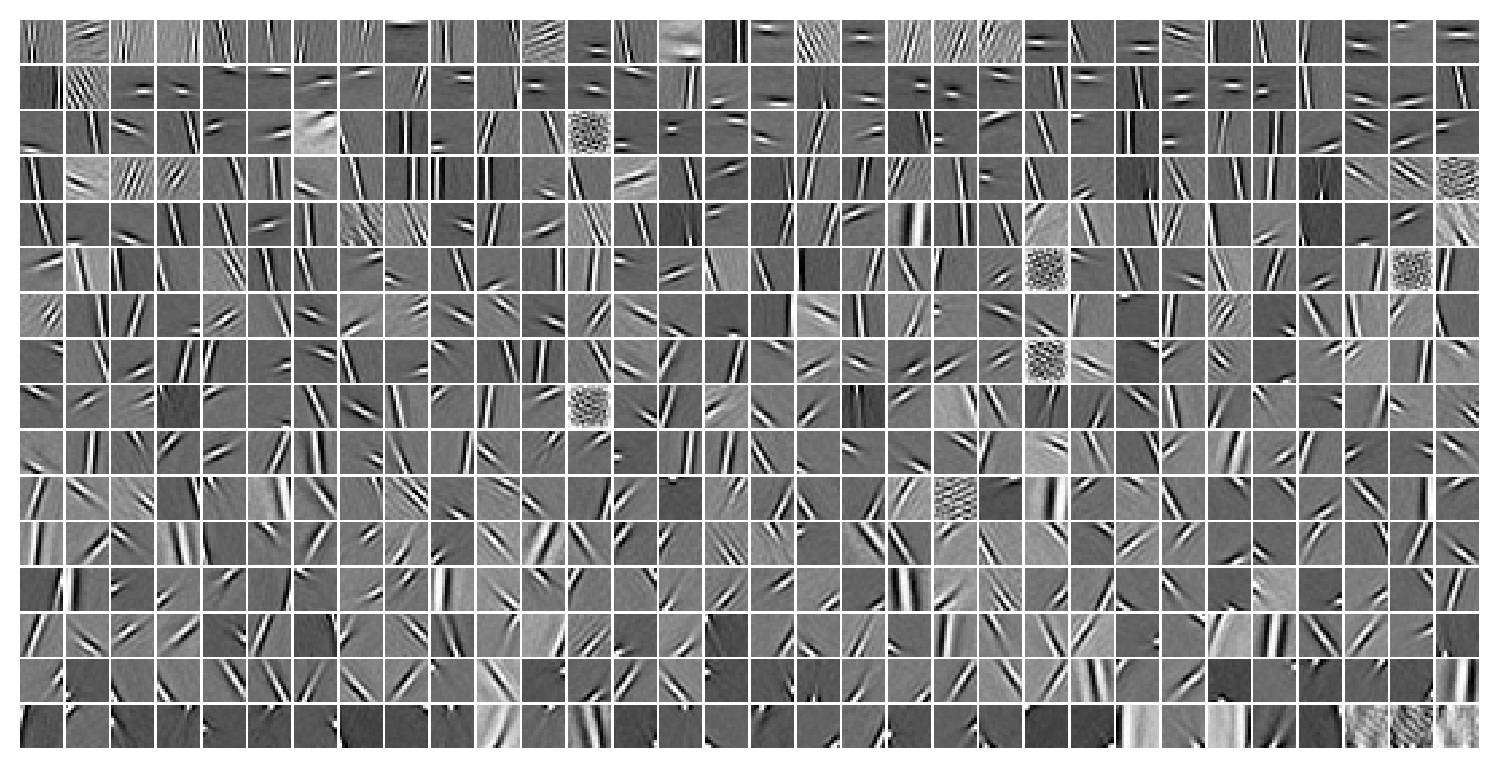

In [9]:
tr.model.show(order=order, dpi=200);

### Good or dead?

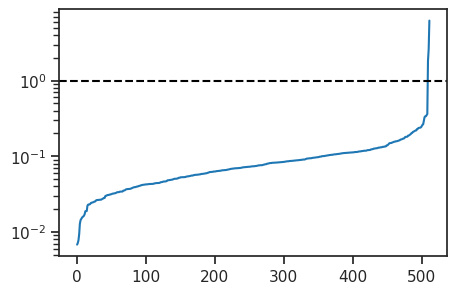

In [10]:
plt.plot(prior_rates)
plt.axhline(1, color='k', ls='--')
plt.yscale('log')
plt.show()

In [11]:
good = prior_rates < 1
good.sum()

509

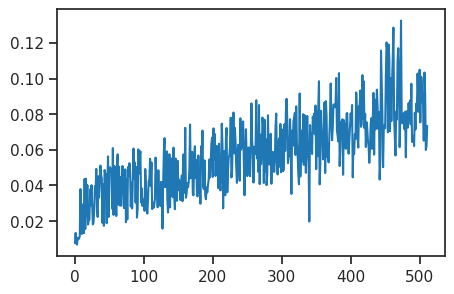

In [12]:
kl_diag = loss['kl_diag'][order]
plt.plot(kl_diag);

In [13]:
kl_diag[-7:].max()

0.10337423

In [14]:
thres = 0.006
dead = kl_diag < thres
dead.sum()

0

In [15]:
set(np.where(dead)[0]).intersection(np.where(~good)[0]), set(np.where(dead)[0]).difference(np.where(~good)[0])

(set(), set())

In [16]:
phi = tonp(tr.model.fc_dec.weight.data)
phi = phi[:, order]
a = phi.T @ phi

a.shape

(512, 512)

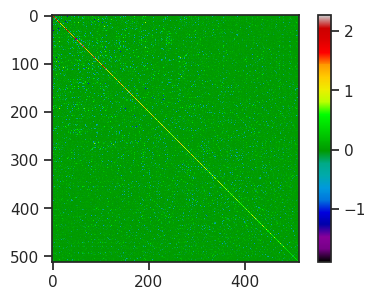

In [17]:
plt.imshow(a, cmap='nipy_spectral')
plt.colorbar()

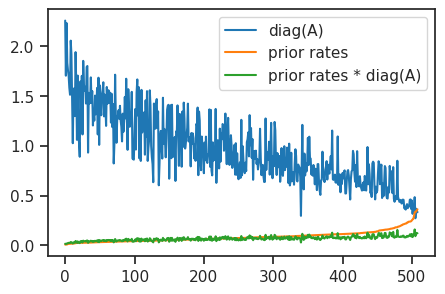

In [18]:
plt.plot(np.diag(a)[good], label='diag(A)')
plt.plot(prior_rates[good], label='prior rates')
plt.plot((prior_rates * np.diag(a))[good], label='prior rates * diag(A)')
plt.legend()
plt.show()

In [43]:
rv = sp_stats.norm(loc=np.log(prior_rates[good]).mean(), scale=np.log(prior_rates[good]).std())
xs = np.linspace(np.log(prior_rates[good]).min() - 0.2, np.log(prior_rates[good]).max() + 1.0, 1000)
pdf = rv.pdf(xs)

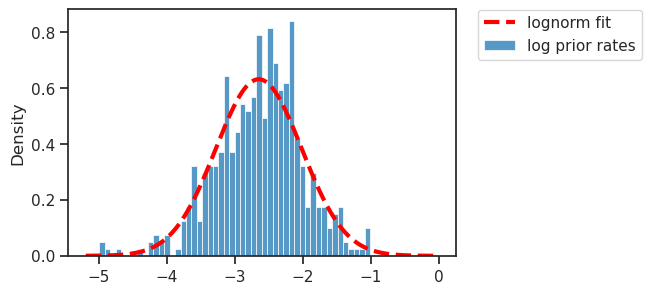

In [47]:
fig, ax = create_figure()

sns.histplot(np.log(prior_rates[good]), stat='density', bins=50, element='bars', label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=3, ls='--', label='lognorm fit')
add_legend(ax)
move_legend(ax, (1.5, 1.03))
plt.show()

In [48]:
sp_stats.kstest(np.log(prior_rates[good]), rv.cdf, alternative='two-sided', method='exact')

KstestResult(statistic=0.03935327289175117, pvalue=0.3994550357210537, statistic_location=-2.671472, statistic_sign=-1)

## Closed-form?

**Compare**:
1) Monte-Carlo estimate
2) Exact

In [49]:
lamb = []
exact = []
estimate = []
estimate_r = []

for x in tqdm(iter(tr.dl_vld), total=len(tr.dl_vld), ncols=50):
    x = x[0]
    with torch.inference_mode():
        dist, log_dr = tr.model.infer(x, t=0.0)
        lamb.append(dist.rate)

        mse, mse_r = [], []
        for _ in range(300):
            # torch.poisson()
            spks = dist.sample()
            y = tr.model.decode(spks)
            mse.append(tr.model.loss_recon(y, x))
            # rsample()
            spks = dist.rsample()
            y = tr.model.decode(spks)
            mse_r.append(tr.model.loss_recon(y, x))

        estimate.append(tonp(torch.stack(mse).mean(0)))
        estimate_r.append(tonp(torch.stack(mse_r).mean(0)))
        exact.append(tonp(tr.model.loss_recon_exact(x)[0]))

lamb = torch.cat(lamb)
exact, estimate, estimate_r = cat_map([
    exact, estimate, estimate_r,
])
exact.shape, estimate.shape, lamb.shape

100%|█████████████| 29/29 [00:07<00:00,  3.69it/s]


((28224,), (28224,), torch.Size([28224, 512]))

In [50]:
exact.mean(), estimate.mean(), estimate_r.mean()

(134.49033, 134.4877, 134.43617)

### Plot vs. Exact

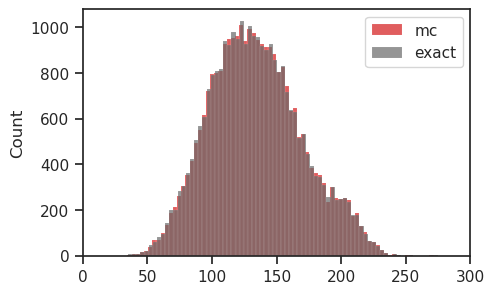

In [53]:
fig, ax = create_figure()

sns.histplot(estimate, color='C3', label='mc')
sns.histplot(exact, color='dimgrey', label='exact', alpha=0.7)

ax.set(xlim=(0, 300))
add_legend(ax)
# move_legend(ax, (1.0, 1.03))
plt.show()

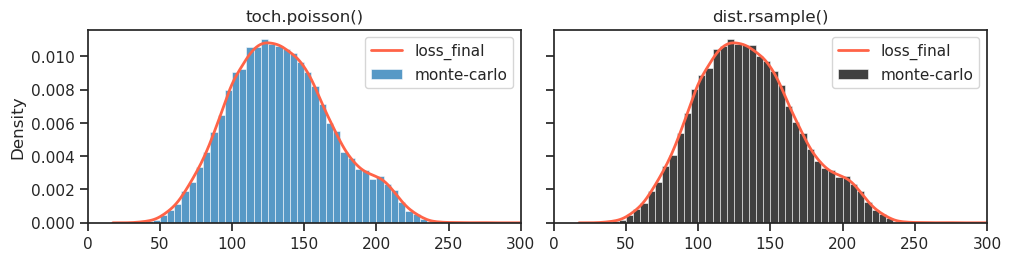

In [57]:
fig, axes = create_figure(1, 2, (10, 2.5), sharey='row', layout='constrained')

xlim = (0, 300)
if xlim is not None:
    bins = np.linspace(min(xlim), max(xlim), (max(xlim) - min(xlim)) // 5 + 1)
else:
    bins = 60
kws = dict(label='monte-carlo', stat='density', element='bars', bins=bins, zorder=1)

sns.histplot(estimate, color='C0', ax=axes[0], **kws)
sns.histplot(estimate_r, color='k', ax=axes[1], **kws)

for ax in axes.flat:
    sns.kdeplot(exact, color='tomato', label='loss_final', clip=(0, 300), lw=2, ax=ax, zorder=2)
    ax.set(xlim=xlim)

axes[0].set_title('toch.poisson()')
axes[1].set_title('dist.rsample()')

add_legend(axes)
plt.show()

In [58]:
sp_stats.pearsonr(estimate, exact)

PearsonRResult(statistic=0.9998123624072852, pvalue=0.0)

In [59]:
sp_stats.pearsonr(estimate_r, exact)

PearsonRResult(statistic=0.9932360423344543, pvalue=0.0)

In [60]:
np.linalg.norm(estimate - exact)

121.96999

In [61]:
np.linalg.norm(estimate_r - exact)

737.63654

In [62]:
delta = np.abs(estimate - exact)
mismatch_order = np.argsort(delta)[::-1]
inds = mismatch_order[:5]

estimate[inds], exact[inds]

(array([1191.9758 , 1283.3756 ,  354.39938,  557.2429 ,  442.56033],
       dtype=float32),
 array([1153.9545 , 1266.6746 ,  368.92993,  571.66003,  429.43588],
       dtype=float32))

In [63]:
delta = np.abs(estimate_r - exact)
mismatch_order = np.argsort(delta)[::-1]
inds = mismatch_order[:5]

estimate_r[inds], exact[inds]

(array([665.3091 , 800.26953, 405.89145, 254.0229 , 341.17166],
       dtype=float32),
 array([1153.9545 , 1266.6746 ,  596.30194,  368.92993,  429.43588],
       dtype=float32))

In [64]:
bad_stim_i = np.where(exact == exact.max())[0].item()
bad_stim_i

4888

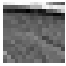

In [65]:
fig, ax = create_figure(dpi=25)
plt.imshow(tonp(tr.dl_vld.dataset.tensors[0][bad_stim_i].squeeze()), cmap='Greys_r')
remove_ticks(ax)
plt.show()

### Verify ```self.loss_recon_exact()``` implementation

In [66]:
tr.model.update_t(0.0)

In [67]:
estimate = []
for _ in tqdm(range(500), ncols=50):
    _, loss, _ = tr.validate()
    estimate.append(loss['mse'])
estimate = np.stack(estimate).mean(0)
estimate.shape

100%|███████████| 500/500 [01:18<00:00,  6.35it/s]


(28224,)

In [68]:
exact = []
for x in iter(tr.dl_vld):
    x = x[0]
    with torch.inference_mode():
        exact.append(tr.model.loss_recon_exact(x)[0])
exact = tonp(torch.concatenate(exact))
exact.shape

(28224,)

In [69]:
sp_stats.pearsonr(estimate, exact)

PearsonRResult(statistic=0.9932173653660723, pvalue=0.0)

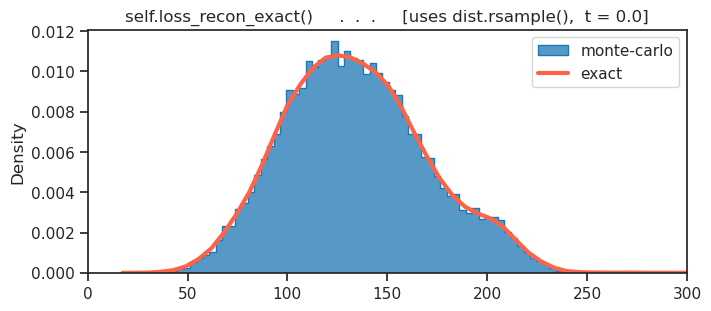

In [70]:
fig, ax = create_figure(1, 1, (7, 3), layout='constrained')

sns.histplot(estimate, color='C0', label='monte-carlo', stat='density', element='step', ax=ax, zorder=1)
sns.kdeplot(exact, color='tomato', label='exact', lw=3, ax=ax, zorder=2)

tit = f'self.loss_recon_exact()     .  .  .     [uses dist.rsample(),  t = {tr.model.temp.item()}]'
ax.set(title=tit, xlim=(0, 300))
add_legend(ax)
plt.show()

In [71]:
estimate.mean(), exact.mean()

(134.42995, 134.49033)

In [74]:
estimate.max(), estimate_r.max(), exact.max()

(802.02405, 800.26953, 1266.6746)

In [75]:
sp_stats.pearsonr(estimate[exact < 300], exact[exact < 300])

PearsonRResult(statistic=0.999774923402666, pvalue=0.0)

In [76]:
estimate[exact < 300].mean(), exact[exact < 300].mean()

(134.30844, 134.31487)

### Now verify for Gaussian

In [35]:
tr, meta = load_model(
    model_name='gaussian_None_DOVES_z-512_<lin|lin>',
    fit_name='ep3600-b1000-lr(0.005)_beta(1:0x0.5)_gr(500)_(2024_04_06,09:03)',
    device=device,
    verbose=True,
)

# params: 394.2 K

In [36]:
tr.model.update_t(1.0)

In [37]:
estimate = []
for _ in tqdm(range(500), ncols=80):
    _, loss, _ = tr.validate()
    estimate.append(loss['mse'])
estimate = np.stack(estimate).mean(0)
estimate.shape

100%|█████████████████████████████████████████| 500/500 [00:48<00:00, 10.31it/s]


(28224,)

In [38]:
exact = []
for x in iter(tr.dl_vld):
    mse = tr.model.loss_recon_exact(x)
    exact.append(mse)
exact = to_np(torch.concatenate(exact))
exact.shape

(28224,)

In [39]:
sp_stats.pearsonr(estimate, exact)

PearsonRResult(statistic=0.9999308566476282, pvalue=0.0)

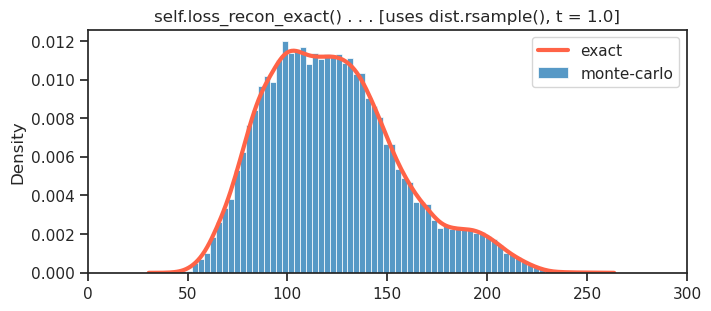

In [40]:
fig, ax = create_figure(1, 1, (7, 3), layout='constrained')

sns.histplot(estimate, color='C0', label='monte-carlo', stat='density', ax=ax, zorder=1)
sns.kdeplot(exact, color='tomato', label='exact', lw=3, ax=ax, zorder=2)

tit = f'self.loss_recon_exact() . . . [uses dist.rsample(), t = {tr.model.temp.item()}]'
ax.set(title=tit, xlim=(0, 300))
add_legend(ax)
plt.show()

In [41]:
exact.mean(), estimate.mean()

(122.71694, 122.7195)

## Check expectations (simulation)

In [42]:
k = 512

w = torch.randn((256, k)) / 20
a = w.T @ w

w.shape, a.shape

(torch.Size([256, 512]), torch.Size([512, 512]))

In [43]:
def fun1(z):
    return (w @ z).squeeze()

def fun2(z):
    return (z.T @ a @ z).squeeze()

In [44]:
from base.distributions import Poisson

lamb = torch.randn((k, 1))
dist = Poisson(lamb * 0.8)

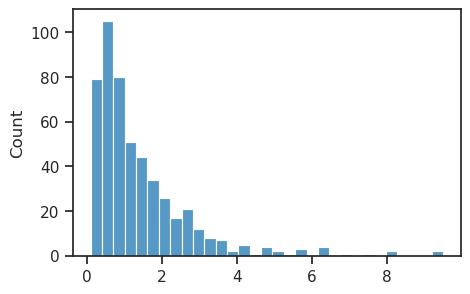

In [45]:
sns.histplot(to_np(dist.rates.squeeze()));

In [46]:
true = fun1(dist.rates)

In [47]:
sampled = []
for _ in range(50000):
    z = dist.sample()
    sampled.append(fun1(z))
sampled = torch.stack(sampled)
sampled.shape

torch.Size([50000, 256])

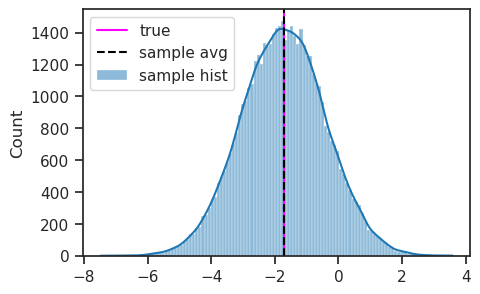

In [48]:
i = 4

ax = sns.histplot(to_np(sampled[:, i]), kde=True, label='sample hist')
ax.axvline(true[i], color='magenta', label='true')
ax.axvline(to_np(sampled[:, i].mean()), color='k', ls='--', label='sample avg')
ax.legend()
plt.show()

In [49]:
true = fun2(dist.rates) + dist.rates.T @ torch.diag(a)

In [50]:
estimates = []
for _ in range(10000):
    z = dist.sample()
    estimates.append(fun2(z))
estimates = torch.stack(estimates)
estimates.shape

torch.Size([10000])

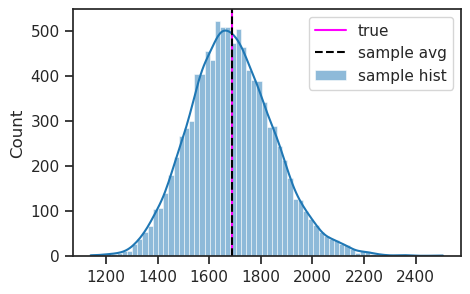

In [51]:
ax = sns.histplot(to_np(estimates), kde=True, label='sample hist')
ax.axvline(true.item(), color='magenta', label='true')
ax.axvline(to_np(estimates.mean()), color='k', ls='--', label='sample avg')
ax.legend()
plt.show()